# 기본 그래프 컨볼루션 구현

In [1]:
import networkx as nx
import numpy as np

In [2]:
# 그래프 객체 생성
G = nx.Graph()

# 그래프에 사용할 색상의 HEX 코드
blue, orange, green = "#1f77b4", "#ff7f0e", "#2ca02c"

# 노드 추가 (노드 번호와 색상 속성)
G.add_nodes_from([
    (1, {"color": blue}),
    (2, {"color": orange}),
    (3, {"color": blue}),
    (4, {"color": green})
])

# 에지 추가
G.add_edges_from([
    (1, 2),
    (2, 3),
    (1, 3),
    (3, 4)
])

# 인접 행렬 생성 및 출력
A = np.asarray(nx.adjacency_matrix(G).todense())
print(A)


[[0 1 1 0]
 [1 0 1 0]
 [1 1 0 1]
 [0 0 1 0]]


In [21]:
# 노드의 색상 속성 원-핫 인코딩 변환

def build_graph_color_label_representation(G, mapping_dict):
    # 노드의 색상 속성을 기반으로 인덱스 배열 생성
    one_hot_idxs = np.array([mapping_dict[v] for v in nx.get_node_attributes(G, 'color').values()])

    # 원-핫 인코딩 배열 초기화
    one_hot_encoding = np.zeros((one_hot_idxs.size, len(mapping_dict)))

    # 원-핫 인코딩 적용
    one_hot_encoding[np.arange(one_hot_idxs.size), one_hot_idxs] = 1
    return one_hot_encoding

# 그래프 객체 생성 및 노드와 에지 추가
G = nx.Graph()
blue, orange, green = "#1f77b4", "#ff7f0e", "#2ca02c"
G.add_nodes_from([(1, {"color": blue}), (2, {"color": orange}), (3, {"color": blue}), (4, {"color": green})])
G.add_edges_from([(1, 2), (2, 3), (1, 3), (3, 4)])

# 색상을 기반으로 한 원-핫 인코딩 생성
X = build_graph_color_label_representation(G, {green: 0, blue: 1, orange: 2})

# 결과 출력
print(X)


[[0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]]


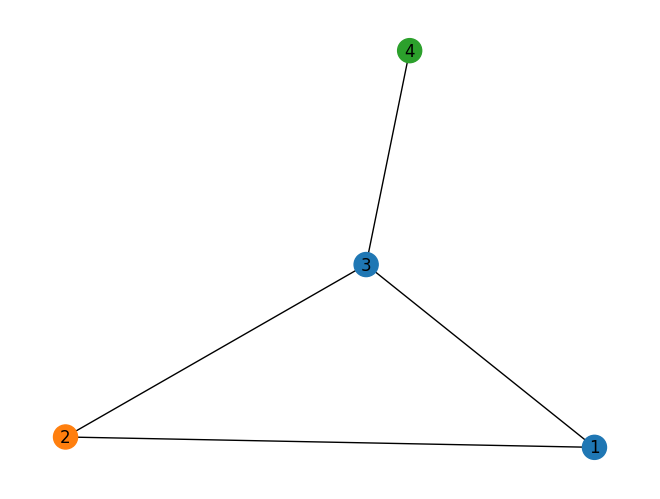

In [4]:
color_map = nx.get_node_attributes(G, 'color').values()
# 그래프 데이터에서 각 노드의 특성을 업데이트하는 방법을 구현
nx.draw(G, with_labels=True, node_color=color_map)

### 그래프 컨볼루션

In [5]:
# 그래프 데이터에서 각 노드의 특성을 업데이트하는 방법을 구현
import numpy as np

# X는 노드의 특성을 나타내는 행렬입니다. 여기서 X.shape[1]은 노드의 특성 수(열, column)를 의미합니다.
f_in, f_out = X.shape[1], 6  # 입력 특성 수와 출력 특성 수를 정의합니다.

# W_1과 W_2는 학습 가능한 가중치 행렬입니다.
W_1 = np.random.rand(f_in, f_out)  # 노드 자체의 특성 변환을 위한 가중치
W_2 = np.random.rand(f_in, f_out)  # 이웃 노드들의 특성 변환을 위한 가중치

# h는 각 노드의 최종 업데이트된 임베딩을 계산합니다.
# np.dot(X, W_1)은 각 노드의 현재 특성에 가중치 W_1을 적용합니다.
# np.dot(np.dot(A, X), W_2)는 인접 행렬 A를 사용하여 이웃 노드들의 정보를 집계한 후 가중치 W_2를 적용합니다.
h = np.dot(X, W_1) + np.dot(np.dot(A, X), W_2)  # 노드의 최종 임베딩 계산


# 처음부터 PyTorch를 사용한 GNN 구현



## NodeNetwork 모델 정의


### Torch 버전 확인 및 업데이트

In [6]:
import torch
print(torch.__version__)

2.1.0+cu118


In [7]:
# PyTorch 설치 (Colab에 기본적으로 설치되어 있음)
# !pip install torch torchvision

# PyTorch Geometric과 필요한 의존성 패키지들 설치
!pip install torch-geometric
!pip install torch-sparse torch-scatter torch-cluster torch-spline-conv -f https://data.pyg.org/whl/torch-2.1.0+cu118.html

# 위 명령에서 torch-1.12.0+cu113 부분은 현재 설치된 PyTorch의 버전과 CUDA 버전에 맞게 조정해야 할 수 있습니다.
# PyTorch와 CUDA의 버전을 확인하려면 다음 명령을 사용합니다:
!python -c "import torch; print(torch.__version__); print(torch.version.cuda)"


Looking in links: https://data.pyg.org/whl/torch-2.1.0+cu118.html
2.1.0+cu118
11.8


In [8]:
!pip install torch-geometric -U

In [9]:
import networkx as nx
import torch
from torch.nn.parameter import Parameter
import numpy as np
import torch.nn.functional as F

In [10]:
class NodeNetwork(torch.nn.Module):
    # 생성자 함수
    def __init__(self, input_features):
        super().__init__()

        # 첫 번째 그래프 컨볼루션 레이어를 초기화합니다. 입력 특성 수와 출력 특성 수는 각각 input_features와 32입니다.
        self.conv_1 = BasicGraphConvolutionLayer(input_features, 32)

        # 두 번째 그래프 컨볼루션 레이어를 초기화합니다. 첫 번째 레이어의 출력 특성 수(32)가 입력으로 사용됩니다.
        self.conv_2 = BasicGraphConvolutionLayer(32, 32)

        # 첫 번째 완전 연결(선형) 레이어를 초기화합니다. 입력 특성 수는 32, 출력 특성 수는 16입니다.
        self.fc_1 = torch.nn.Linear(32, 16)

        # 출력 레이어(또 다른 완전 연결 레이어)를 초기화합니다. 입력 특성 수는 16, 출력 특성 수(클래스 수)는 2입니다.
        self.out_layer = torch.nn.Linear(16, 2)

    # 전방향 패스를 정의합니다.
    def forward(self, X, A, batch_mat):
        # 첫 번째 컨볼루션 레이어를 통과하고 ReLU 활성화 함수를 적용합니다.
        x = F.relu(self.conv_1(X, A))

        # 두 번째 컨볼루션 레이어를 통과하고 ReLU 활성화 함수를 적용합니다.
        x = F.relu(self.conv_2(x, A))

        # 그래프의 모든 노드에서 글로벌 풀링을 적용하여 하나의 벡터로 요약합니다.
        output = global_sum_pool(x, batch_mat)

        # 첫 번째 완전 연결 레이어를 통과합니다.
        output = self.fc_1(output)

        # 출력 레이어를 통과합니다.
        output = self.out_layer(output)

        # 소프트맥스 함수를 적용하여 각 클래스에 대한 확률을 계산합니다.
        return F.softmax(output, dim=1)


## NodeNetwork의 그래프 컨볼루션 계층 코딩

In [11]:
class BasicGraphConvolutionLayer(torch.nn.Module):
    # 초기화 함수
    def __init__(self, in_channels, out_channels):
        super().__init__()  # 상위 클래스(torch.nn.Module)의 초기화 함수 호출
        self.in_channels = in_channels  # 입력 채널의 수
        self.out_channels = out_channels  # 출력 채널의 수

        # 학습 가능한 가중치 W2와 W1 초기화
        # W2는 각 이웃 노드의 특징을 변환하는 데 사용됨
        self.W2 = Parameter(torch.rand((in_channels, out_channels), dtype=torch.float32))

        # W1은 자기 자신 노드의 특징을 변환하는 데 사용됨
        self.W1 = Parameter(torch.rand((in_channels, out_channels), dtype=torch.float32))

        # 학습 가능한 편향(bias) 초기화
        self.bias = Parameter(torch.zeros(out_channels, dtype=torch.float32))

    # 순방향 전파 함수
    def forward(self, X, A):

        # potential_msgs는 X와 W2의 행렬 곱셈을 통해 이웃 노드의 특징을 변환
        potential_msgs = torch.mm(X, self.W2)

        # propagated_msgs는 변환된 이웃 노드의 특징들을 인접 행렬 A를 통해 누적
        propagated_msgs = torch.mm(A, potential_msgs)

        # root_update는 X와 W1의 행렬 곱셈을 통해 자기 자신 노드의 특징을 변환
        root_update = torch.mm(X, self.W1)

        # output은 이웃 노드와 자기 자신의 특징 변환 결과를 합친 후, 편향을 추가
        output = propagated_msgs + root_update + self.bias
        return output


## 다양한 크기의 그래프를 다루기 위한 글로벌 풀링 계층 추가

### 그래프의 모든 노드 임베딩을 하나의 벡터로 합산하는 글로벌 풀링

In [22]:
# 글로벌 풀링

def global_sum_pool(X, batch_mat):
    # batch_mat이 None이거나 1차원 텐서인 경우,
    # 즉, 배치 처리가 필요 없는 경우에 해당합니다.
    if batch_mat is None or batch_mat.dim() == 1:

        # X의 0번째 차원(행 방향)에 대해 모든 요소들의 합을 구합니다.
        # 이 연산은 모든 노드 임베딩을 하나의 벡터로 합산합니다.
        # 그 후, 결과를 2차원 텐서로 변환하기 위해 unsqueeze(0)을 사용합니다.
        return torch.sum(X, dim=0).unsqueeze(0)

    else:

        # 배치 처리가 필요한 경우,
        # batch_mat를 사용하여 각 그래프의 노드 임베딩을 개별적으로 합산합니다.
        # torch.mm은 행렬 곱셈을 수행하는 PyTorch 함수입니다.
        # 여기서 batch_mat는 각 그래프의 노드 임베딩을 선택하는 데 사용됩니다.
        return torch.mm(batch_mat, X)


### 각 그래프의 노드들이 어디에 위치하는지 나타내며, 글로벌 풀링 과정에 사용

In [13]:
# 각 그래프가 배치 내에서 차지하는 위치를 표시하는 배치 텐서 생성

def get_batch_tensor(graph_sizes):

    # 각 그래프의 시작 인덱스를 계산합니다.
    # 이는 각 그래프가 전체 배치 텐서에서 어디서 시작되는지를 나타냅니다.
    starts = [sum(graph_sizes[:idx]) for idx in range(len(graph_sizes))]

    # 각 그래프의 종료 인덱스를 계산합니다.
    # 이는 각 그래프가 전체 배치 텐서에서 어디서 끝나는지를 나타냅니다.
    stops = [starts[idx] + graph_sizes[idx] for idx in range(len(graph_sizes))]

    # 전체 배치 텐서의 길이를 계산합니다.
    tot_len = sum(graph_sizes)

    # 배치의 크기, 즉 그래프의 수를 계산합니다.
    batch_size = len(graph_sizes)

    # 배치 텐서를 초기화합니다. 이 텐서는 각 그래프의 위치를 나타내는 데 사용됩니다.
    batch_mat = torch.zeros([batch_size, tot_len]).float()

    # 각 그래프에 대해 배치 텐서 내에서 해당 그래프의 위치를 표시합니다.
    for idx, (start, stop) in enumerate(zip(starts, stops)):
        # 그래프의 시작점부터 끝점까지 1로 설정합니다.
        batch_mat[idx, start:stop] = 1

    # 완성된 배치 텐서를 반환합니다.
    return batch_mat


### 모든 그래프의 정보를 결헙한 결과를 반환하여 그래프 신경망의 입력으로 사용할 수 있게 함

In [14]:
# 개별 그래프 데이터들을 한 배치로 모으는 작업 수행
# 그래프 데이터셋을 배치 단위로 묶을 때 사용, PyTorch의 'DataLoader'에 의해 각 배치가 처리될 때 호출됨

def collate_graphs(batch):

    # 각 그래프의 인접 행렬을 가져옵니다.
    adj_mats = [graph['A'] for graph in batch]

    # 각 인접 행렬의 크기를 가져옵니다.
    sizes = [A.size(0) for A in adj_mats]

    # 전체 배치에서의 노드 수를 계산합니다.
    tot_size = sum(sizes)

    # 배치 행렬을 생성합니다.
    batch_mat = get_batch_tensor(sizes)

    # 각 그래프의 특성 행렬을 연결하여 하나의 큰 행렬을 만듭니다.
    feat_mats = torch.cat([graph['X'] for graph in batch], dim=0)

    # 각 그래프의 레이블을 연결합니다.
    labels = torch.cat([graph['y'] for graph in batch], dim=0)

    # 배치에 있는 모든 그래프의 인접 행렬을 하나의 큰 행렬로 결합합니다.
    batch_adj = torch.zeros([tot_size, tot_size], dtype=torch.float32)
    accum = 0
    for adj in adj_mats:
        # 각 그래프의 크기를 가져옵니다.
        g_size = adj.shape[0]

        # 큰 인접 행렬에 각 그래프의 인접 행렬을 배치합니다.
        batch_adj[accum:accum+g_size, accum:accum+g_size] = adj
        accum += g_size

    # 최종적으로 생성된 통합 그래프의 표현과 레이블을 딕셔너리 형태로 반환합니다.
    repr_and_label = {
            'A': batch_adj,
            'X': feat_mats,
            'y': labels,
            'batch': batch_mat}

    return repr_and_label


## DataLoader 준비

In [15]:
# NetworkX로 생성된 그래프 'G' 에 대한 전처리

def get_graph_dict(G, mapping_dict):

    # 네트워크X 그래프 G의 딕셔너리 표현을 생성하는 함수
    A = torch.from_numpy(np.asarray(nx.adjacency_matrix(G).todense())).float()

    # 첫 번째 예제 그래프에서 소개된 build_graph_color_label_representation() 함수 사용
    X = torch.from_numpy(build_graph_color_label_representation(G, mapping_dict)).float()

    # 실제 작업이 없으므로 레이블을 임의로 설정
    y = torch.tensor([[1,0]]).float()
    return {'A': A, 'X': X, 'y': y, 'batch': None}


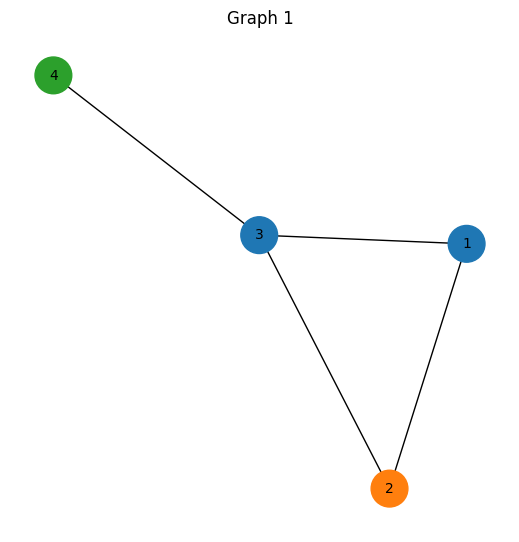

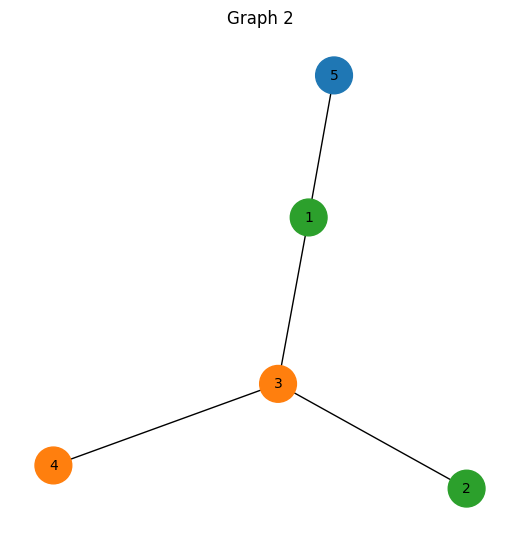

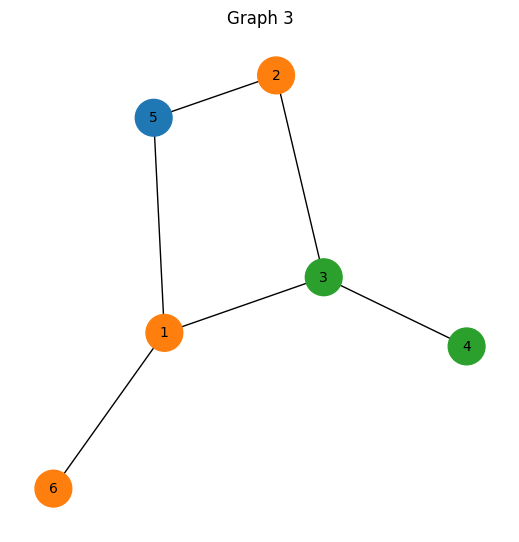

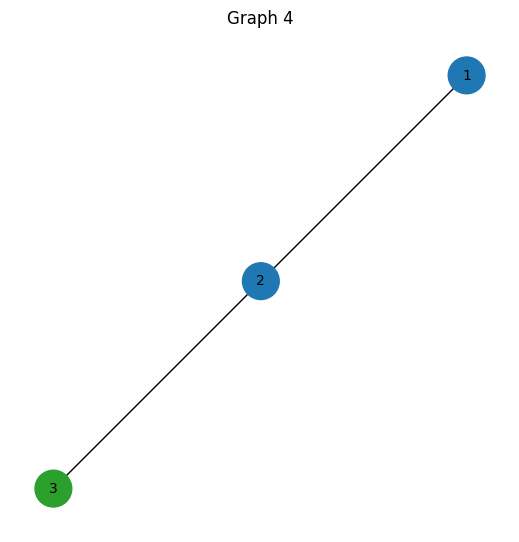

In [16]:
# 데이터셋으로 처리할 4개의 그래프 생성
blue, orange, green = "#1f77b4", "#ff7f0e","#2ca02c"
mapping_dict = {green: 0, blue: 1, orange: 2}

# 첫 번째 그래프 G1 생성
G1 = nx.Graph()
# G1에 노드 추가. 각 노드에는 색깔을 나타내는 속성 부여
G1.add_nodes_from([
    (1, {"color": blue}),
    (2, {"color": orange}),
    (3, {"color": blue}),
    (4, {"color": green})
])
# G1에 간선 추가. 각 숫자 쌍은 연결된 노드를 나타냄
G1.add_edges_from([(1, 2), (2, 3), (1, 3), (3, 4)])

# 두 번째 그래프 G2 생성 및 노드와 간선 추가
G2 = nx.Graph()
G2.add_nodes_from([
    (1, {"color": green}),
    (2, {"color": green}),
    (3, {"color": orange}),
    (4, {"color": orange}),
    (5, {"color": blue})
])
G2.add_edges_from([(2, 3), (3, 4), (3, 1), (5, 1)])

# 세 번째 그래프 G3 생성 및 노드와 간선 추가
G3 = nx.Graph()
G3.add_nodes_from([
    (1, {"color": orange}),
    (2, {"color": orange}),
    (3, {"color": green}),
    (4, {"color": green}),
    (5, {"color": blue}),
    (6, {"color": orange})
])
G3.add_edges_from([(2, 3), (3, 4), (3, 1), (5, 1), (2, 5), (6, 1)])

# 네 번째 그래프 G4 생성 및 노드와 간선 추가
G4 = nx.Graph()
G4.add_nodes_from([
    (1, {"color": blue}),
    (2, {"color": blue}),
    (3, {"color": green})
])
G4.add_edges_from([(1, 2), (2, 3)])

# 각 그래프를 딕셔너리 형태로 변환하여 리스트에 저장
graph_list = [get_graph_dict(graph, mapping_dict) for graph in [G1, G2, G3, G4]]


import matplotlib.pyplot as plt
import networkx as nx

# 그래프 시각화 함수
def visualize_graph(G, title):
    plt.figure(figsize=(5, 5))
    colors = [G.nodes[node]['color'] for node in G.nodes()]
    nx.draw(G, with_labels=True, node_color=colors, node_size=700, font_size=10)
    plt.title(title)

# 각 그래프 시각화
visualize_graph(G1, "Graph 1")
visualize_graph(G2, "Graph 2")
visualize_graph(G3, "Graph 3")
visualize_graph(G4, "Graph 4")


In [17]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class ExampleDataset(Dataset):

    # ExampleDataset 클래스는 PyTorch의 Dataset 클래스를 상속받아 정의됩니다.
    # 이 클래스는 그래프 목록을 사용하여 간단한 PyTorch 데이터셋을 생성합니다.

    def __init__(self, graph_list):
        # 생성자에서는 그래프 리스트를 받아 객체의 graphs 속성에 저장합니다.
        # 이 리스트는 그래프의 딕셔너리 형태의 표현들을 포함합니다.
        self.graphs = graph_list

    def __len__(self):
        # __len__ 메서드는 데이터셋의 총 길이(그래프의 개수)를 반환합니다.
        return len(self.graphs)

    def __getitem__(self, idx):
        # __getitem__ 메서드는 주어진 인덱스(idx)에 해당하는 그래프를 반환합니다.
        # 이 메서드는 DataLoader가 데이터셋에서 데이터를 추출하는 데 사용됩니다.
        mol_rep = self.graphs[idx]
        return mol_rep


In [18]:
# 사용자 정의 데이터셋 'ExampleDataset'을 사용하여 데이터셋 객체 생성
dset = ExampleDataset(graph_list)

# DataLoader를 사용하여 데이터셋에서 데이터를 배치 단위로 불러오는 설정
loader = DataLoader(
    dset,                 # 불러올 데이터셋
    batch_size=2,         # 한 번에 불러올 데이터의 수 (배치 크기)
    shuffle=False,        # 데이터를 섞지 않음 (순차적으로 불러옴)
    collate_fn=collate_graphs  # 사용자 정의 데이터 결합 함수
)


## NodeNetwork을 사용한 예측

In [19]:
# 난수 생성기의 시드 값을 설정
torch.manual_seed(123)

# 노드 특성 수 설정
node_features = 3

# 사용자 정의 그래프 신경망 모델 'NodeNetwork' 초기화
net = NodeNetwork(node_features)


In [20]:
# 결과를 저장할 빈 리스트 생성
batch_results = []

#배치 단위 예측
# 데이터 로더를 통해 각 배치 데이터에 대해 반복
for b in loader:

    # DataLoader를 통해 배치 데이터를 순회하면서 예측 수행
    batch_results.append(net(b['X'], b['A'], b['batch']).detach())

#단일 그래프 예측
# 데이터셋에서 첫 번째 그래프 데이터 추출
G1_rep = dset[1]

# 단일 그래프 데이터에 대한 모델의 결과 계산
G1_single = net(G1_rep['X'], G1_rep['A'], G1_rep['batch']).detach()


# 첫 번째 배치의 결과 추출
G1_batch = batch_results[0][1]


# 단일 그래프 데이터의 결과와 첫 번째 배치 결과가 동일한지 비교
torch.all(torch.isclose(G1_single, G1_batch))


tensor(True)